In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset02/BBox_List_2017.csv
/kaggle/input/dataset02/Data_Entry_2017_v2020.csv
/kaggle/input/dataset02/images_012/images/00029715_002.png
/kaggle/input/dataset02/images_012/images/00029594_001.png
/kaggle/input/dataset02/images_012/images/00029863_000.png
/kaggle/input/dataset02/images_012/images/00029118_000.png
/kaggle/input/dataset02/images_012/images/00029548_008.png
/kaggle/input/dataset02/images_012/images/00030003_000.png
/kaggle/input/dataset02/images_012/images/00029358_011.png
/kaggle/input/dataset02/images_012/images/00030695_004.png
/kaggle/input/dataset02/images_012/images/00029276_008.png
/kaggle/input/dataset02/images_012/images/00030323_021.png
/kaggle/input/dataset02/images_012/images/00030130_000.png
/kaggle/input/dataset02/images_012/images/00029053_000.png
/kaggle/input/dataset02/images_012/images/00028987_016.png
/kaggle/input/dataset02/images_012/images/00030249_001.png
/kaggle/input/dataset02/images_012/images/00028595_000.png
/kaggle/input/dataset0

In [2]:
import os
import cv2
import math
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

from sklearn.metrics import roc_auc_score


In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMG_SIZE = 224
BATCH_GLOBAL = 32
BATCH_LOCAL = 16
BATCH_FUSION = 16

EPOCHS_GLOBAL = 10
EPOCHS_LOCAL = 8
EPOCHS_FUSION = 5

NUM_CLASSES = 15
TAU = 0.7   # attention threshold

IMAGE_ROOTS = [
    "/kaggle/input/dataset02/images_001/images",
    "/kaggle/input/dataset02/images_012/images"
]


In [4]:
labels_df = pd.read_csv(
    "/kaggle/input/dataset02/Data_Entry_2017_v2020.csv"
)

DISEASES = [
    "Atelectasis","Cardiomegaly","Effusion","Infiltration",
    "Mass","Nodule","Pneumonia","Pneumothorax",
    "Consolidation","Edema","Emphysema","Fibrosis",
    "Pleural_Thickening","Hernia"
]


In [5]:
def encode_labels(label_str):
    vec = np.zeros(NUM_CLASSES, dtype=np.float32)
    if label_str == "No Finding":
        vec[-1] = 1.0
        return vec
    for d in label_str.split("|"):
        if d in DISEASES:
            vec[DISEASES.index(d)] = 1.0
    return vec

labels_df["target"] = labels_df["Finding Labels"].apply(encode_labels)


In [6]:
unique_patients = labels_df["Patient ID"].unique()
random.shuffle(unique_patients)

n = len(unique_patients)
train_p = set(unique_patients[:int(0.7*n)])
val_p   = set(unique_patients[int(0.7*n):int(0.8*n)])

train_df = labels_df[labels_df["Patient ID"].isin(train_p)]
val_df   = labels_df[labels_df["Patient ID"].isin(val_p)]


In [7]:
def resolve_image_path(img_name):
    for root in IMAGE_ROOTS:
        path = os.path.join(root, img_name)
        if os.path.exists(path):
            return path
    return None


In [8]:
class ChestDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = resolve_image_path(row["Image Index"])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img = self.transform(img)
        label = torch.tensor(row["target"])
        return img, label


In [9]:
train_tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
])


In [10]:
class GlobalBranch(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(base.children())[:-2])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Linear(2048, NUM_CLASSES)

    def forward(self, x):
        f = self.features(x)
        p = self.pool(f).flatten(1)
        return self.fc(p), f


In [11]:
def extract_attention_crop(image, feature_map):
    with torch.no_grad():
        heatmap = torch.abs(feature_map).max(1)[0][0]
        heatmap = heatmap.cpu().numpy()
        heatmap = heatmap / heatmap.max()

        mask = heatmap > TAU
        ys, xs = np.where(mask)

        if len(xs) == 0:
            return image  # fallback

        xmin, xmax = xs.min(), xs.max()
        ymin, ymax = ys.min(), ys.max()

        H, W = IMG_SIZE, IMG_SIZE
        xmin = max(0, int(xmin * W / heatmap.shape[1]))
        xmax = min(W, int(xmax * W / heatmap.shape[1]))
        ymin = max(0, int(ymin * H / heatmap.shape[0]))
        ymax = min(H, int(ymax * H / heatmap.shape[0]))

        crop = image[:, ymin:ymax, xmin:xmax]
        if crop.numel() == 0:
            return image

        return nn.functional.interpolate(
            crop.unsqueeze(0),
            size=(IMG_SIZE, IMG_SIZE),
            mode="bilinear",
            align_corners=False
        ).squeeze(0)


In [12]:
class LocalBranch(GlobalBranch):
    pass

class FusionBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(4096, NUM_CLASSES)

    def forward(self, g_feat, l_feat):
        x = torch.cat([g_feat, l_feat], dim=1)
        return self.fc(x)


In [13]:
criterion = nn.BCEWithLogitsLoss()


In [14]:
def build_existing_image_set():
    existing = set()
    for root in IMAGE_ROOTS:
        for f in os.listdir(root):
            if f.endswith(".png"):
                existing.add(f)
    return existing

existing_images = build_existing_image_set()

print(f"Images on disk: {len(existing_images)}")
print(f"CSV rows before filter: {len(labels_df)}")

labels_df = labels_df[labels_df["Image Index"].isin(existing_images)].reset_index(drop=True)

print(f"CSV rows after filter: {len(labels_df)}")


Images on disk: 12120
CSV rows before filter: 112120
CSV rows after filter: 12120


In [15]:
unique_patients = labels_df["Patient ID"].unique()
np.random.shuffle(unique_patients)

n = len(unique_patients)
train_p = set(unique_patients[:int(0.7*n)])
val_p   = set(unique_patients[int(0.7*n):int(0.8*n)])

train_df = labels_df[labels_df["Patient ID"].isin(train_p)].reset_index(drop=True)
val_df   = labels_df[labels_df["Patient ID"].isin(val_p)].reset_index(drop=True)

print("Train samples:", len(train_df))
print("Val samples:", len(val_df))


Train samples: 8271
Val samples: 1364


In [16]:
ds = ChestDataset(train_df, train_tf)
img, label = ds[0]

print(img.shape)
print(label)


torch.Size([3, 224, 224])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [17]:
global_model = GlobalBranch().to(DEVICE)
optimizer_g = optim.SGD(global_model.parameters(), 0.01, momentum=0.9)

train_loader = DataLoader(
    ChestDataset(train_df, train_tf),
    batch_size=BATCH_GLOBAL,
    shuffle=True,
    num_workers=2
)

for epoch in range(EPOCHS_GLOBAL):
    global_model.train()
    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        out, _ = global_model(imgs)
        loss = criterion(out, labels)

        optimizer_g.zero_grad()
        loss.backward()
        optimizer_g.step()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 223MB/s]
100%|██████████| 259/259 [01:41<00:00,  2.54it/s]


In [18]:
# ============================================================
# Cell 14 — Freeze Global Branch
# ============================================================

# Freeze all parameters of the trained global model
for param in global_model.parameters():
    param.requires_grad = False

# Switch to evaluation mode
global_model.eval()

print("✅ Global branch frozen and set to eval mode")


✅ Global branch frozen and set to eval mode


In [19]:
# ============================================================
# Cell 15 — Initialize Local Branch
# ============================================================

local_model = LocalBranch().to(DEVICE)

optimizer_l = optim.SGD(
    local_model.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=1e-4
)

print("✅ Local branch initialized")


✅ Local branch initialized


In [20]:
# ============================================================
# Cell 16 — Local Branch DataLoader
# ============================================================

local_loader = DataLoader(
    ChestDataset(train_df, train_tf),
    batch_size=BATCH_LOCAL,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

print("✅ Local DataLoader ready")


✅ Local DataLoader ready


In [21]:
# ============================================================
# Cell 17 — Train Local Branch
# ============================================================

for epoch in range(EPOCHS_LOCAL):
    local_model.train()
    running_loss = 0.0

    for imgs, labels in tqdm(local_loader, desc=f"Local Epoch {epoch+1}/{EPOCHS_LOCAL}"):
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        # --- Generate attention crops from frozen global model ---
        with torch.no_grad():
            _, fmap = global_model(imgs)

        crops = torch.stack([
            extract_attention_crop(imgs[i], fmap[i:i+1])
            for i in range(imgs.size(0))
        ])

        outputs, _ = local_model(crops)
        loss = criterion(outputs, labels)

        optimizer_l.zero_grad()
        loss.backward()
        optimizer_l.step()

        running_loss += loss.item()

    print(f"✅ Local Epoch {epoch+1} | Loss: {running_loss/len(local_loader):.4f}")


Local Epoch 1/8: 100%|██████████| 517/517 [01:49<00:00,  4.70it/s]


✅ Local Epoch 1 | Loss: 0.2460


Local Epoch 2/8: 100%|██████████| 517/517 [01:49<00:00,  4.73it/s]


✅ Local Epoch 2 | Loss: 0.2126


Local Epoch 3/8: 100%|██████████| 517/517 [01:48<00:00,  4.77it/s]


✅ Local Epoch 3 | Loss: 0.2099


Local Epoch 4/8: 100%|██████████| 517/517 [01:48<00:00,  4.77it/s]


✅ Local Epoch 4 | Loss: 0.2071


Local Epoch 5/8: 100%|██████████| 517/517 [01:48<00:00,  4.74it/s]


✅ Local Epoch 5 | Loss: 0.2050


Local Epoch 6/8: 100%|██████████| 517/517 [01:49<00:00,  4.72it/s]


✅ Local Epoch 6 | Loss: 0.2045


Local Epoch 7/8: 100%|██████████| 517/517 [01:49<00:00,  4.74it/s]


✅ Local Epoch 7 | Loss: 0.2027


Local Epoch 8/8: 100%|██████████| 517/517 [01:49<00:00,  4.72it/s]

✅ Local Epoch 8 | Loss: 0.2031


In [22]:
# ============================================================
# Cell 18 — Freeze Local Branch
# ============================================================

for param in local_model.parameters():
    param.requires_grad = False

local_model.eval()

print("✅ Local branch frozen")


✅ Local branch frozen


In [23]:
# ============================================================
# Cell 19 — Fusion Branch
# ============================================================

fusion_model = FusionBranch().to(DEVICE)

optimizer_f = optim.SGD(
    fusion_model.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=1e-4
)

print("✅ Fusion branch initialized")


✅ Fusion branch initialized


In [24]:
# ============================================================
# Cell 20 — Fusion DataLoader
# ============================================================

fusion_loader = DataLoader(
    ChestDataset(train_df, train_tf),
    batch_size=BATCH_FUSION,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

print("✅ Fusion DataLoader ready")


✅ Fusion DataLoader ready


In [25]:
# ============================================================
# Cell 21 — Train Fusion Branch
# ============================================================

for epoch in range(EPOCHS_FUSION):
    fusion_model.train()
    running_loss = 0.0

    for imgs, labels in tqdm(fusion_loader, desc=f"Fusion Epoch {epoch+1}/{EPOCHS_FUSION}"):
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.no_grad():
            _, g_fmap = global_model(imgs)

            crops = torch.stack([
                extract_attention_crop(imgs[i], g_fmap[i:i+1])
                for i in range(imgs.size(0))
            ])

            _, l_fmap = local_model(crops)

            g_feat = torch.max(g_fmap, dim=3)[0].max(dim=2)[0]
            l_feat = torch.max(l_fmap, dim=3)[0].max(dim=2)[0]

        logits = fusion_model(g_feat, l_feat)
        loss = criterion(logits, labels)

        optimizer_f.zero_grad()
        loss.backward()
        optimizer_f.step()

        running_loss += loss.item()

    print(f"✅ Fusion Epoch {epoch+1} | Loss: {running_loss/len(fusion_loader):.4f}")


Fusion Epoch 1/5: 100%|██████████| 517/517 [01:43<00:00,  4.98it/s]


✅ Fusion Epoch 1 | Loss: 0.1782


Fusion Epoch 2/5: 100%|██████████| 517/517 [01:46<00:00,  4.88it/s]


✅ Fusion Epoch 2 | Loss: 0.1601


Fusion Epoch 3/5: 100%|██████████| 517/517 [01:43<00:00,  4.99it/s]


✅ Fusion Epoch 3 | Loss: 0.1567


Fusion Epoch 4/5: 100%|██████████| 517/517 [01:46<00:00,  4.84it/s]


✅ Fusion Epoch 4 | Loss: 0.1548


Fusion Epoch 5/5: 100%|██████████| 517/517 [01:44<00:00,  4.94it/s]

✅ Fusion Epoch 5 | Loss: 0.1538


In [26]:
# ============================================================
# Cell 22 — Save Models
# ============================================================

torch.save(global_model.state_dict(), "global_branch.pth")
torch.save(local_model.state_dict(), "local_branch.pth")
torch.save(fusion_model.state_dict(), "fusion_branch.pth")

print("✅ All AG-CNN models saved")


✅ All AG-CNN models saved


In [27]:
# ============================================================
# Cell 23 — Validation DataLoader
# ============================================================

val_loader = DataLoader(
    ChestDataset(val_df, val_tf),
    batch_size=8,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("✅ Validation loader ready")


✅ Validation loader ready


In [28]:
from sklearn.metrics import roc_auc_score

def evaluate_auc(model_type="global"):
    """
    model_type: 'global', 'local', or 'fusion'
    """
    global_model.eval()
    local_model.eval()
    fusion_model.eval()

    y_true, y_pred = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Evaluating {model_type}"):
            imgs = imgs.to(DEVICE)
            labels = labels.cpu().numpy()

            if model_type == "global":
                logits, _ = global_model(imgs)
                preds = torch.sigmoid(logits)

            elif model_type == "local":
                _, fmap = global_model(imgs)
                crops = torch.stack([
                    extract_attention_crop(imgs[i], fmap[i:i+1])
                    for i in range(imgs.size(0))
                ])
                logits, _ = local_model(crops)
                preds = torch.sigmoid(logits)

            else:  # fusion
                _, g_fmap = global_model(imgs)
                crops = torch.stack([
                    extract_attention_crop(imgs[i], g_fmap[i:i+1])
                    for i in range(imgs.size(0))
                ])
                _, l_fmap = local_model(crops)

                g_feat = torch.max(g_fmap, dim=3)[0].max(dim=2)[0]
                l_feat = torch.max(l_fmap, dim=3)[0].max(dim=2)[0]

                logits = fusion_model(g_feat, l_feat)
                preds = torch.sigmoid(logits)

            y_true.append(labels)
            y_pred.append(preds.cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    aucs = []
    for i in range(NUM_CLASSES - 1):  # exclude "No Finding"
        try:
            aucs.append(roc_auc_score(y_true[:, i], y_pred[:, i]))
        except:
            continue

    return aucs, np.mean(aucs)


In [29]:
global_auc, global_mean = evaluate_auc("global")
local_auc, local_mean   = evaluate_auc("local")
fusion_auc, fusion_mean = evaluate_auc("fusion")

print("\n==== PAPER RESULTS (AUC) ====")
print(f"Global  Mean AUC : {global_mean:.4f}")
print(f"Local   Mean AUC : {local_mean:.4f}")
print(f"Fusion  Mean AUC : {fusion_mean:.4f}")


Evaluating fusion: 100%|██████████| 171/171 [00:17<00:00,  9.65it/s]


==== PAPER RESULTS (AUC) ====
Global  Mean AUC : 0.7668
Local   Mean AUC : 0.6688
Fusion  Mean AUC : 0.7600


In [30]:
for i, d in enumerate(DISEASES):
    print(f"{d:20s} | "
          f"G: {global_auc[i]:.3f}  "
          f"L: {local_auc[i]:.3f}  "
          f"F: {fusion_auc[i]:.3f}")


Atelectasis          | G: 0.754  L: 0.725  F: 0.730
Cardiomegaly         | G: 0.869  L: 0.703  F: 0.885
Effusion             | G: 0.850  L: 0.774  F: 0.850
Infiltration         | G: 0.677  L: 0.618  F: 0.663
Mass                 | G: 0.694  L: 0.555  F: 0.687
Nodule               | G: 0.623  L: 0.547  F: 0.639
Pneumonia            | G: 0.762  L: 0.625  F: 0.751
Pneumothorax         | G: 0.720  L: 0.655  F: 0.695
Consolidation        | G: 0.747  L: 0.713  F: 0.733
Edema                | G: 0.850  L: 0.802  F: 0.832
Emphysema            | G: 0.765  L: 0.584  F: 0.756
Fibrosis             | G: 0.765  L: 0.650  F: 0.763
Pleural_Thickening   | G: 0.706  L: 0.603  F: 0.681
Hernia               | G: 0.953  L: 0.808  F: 0.974


libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


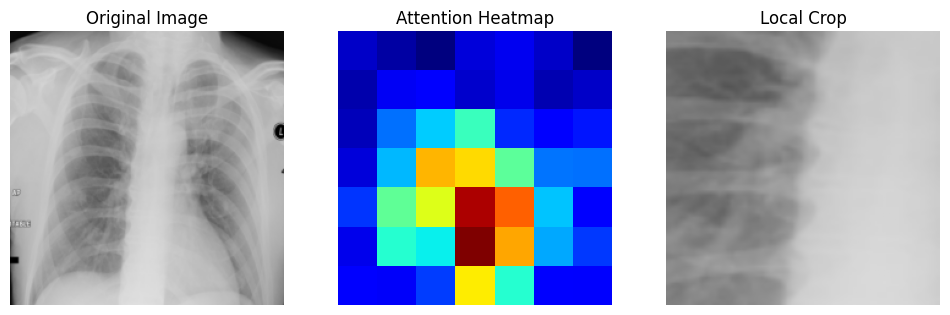

In [31]:
import matplotlib.pyplot as plt

global_model.eval()

imgs, _ = next(iter(val_loader))
imgs = imgs.to(DEVICE)

with torch.no_grad():
    _, fmap = global_model(imgs)

img = imgs[0].cpu().permute(1,2,0)
heatmap = torch.abs(fmap[0]).max(0)[0].cpu()

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(heatmap, cmap="jet")
plt.title("Attention Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
crop = extract_attention_crop(imgs[0], fmap[0:1]).cpu().permute(1,2,0)
plt.imshow(crop)
plt.title("Local Crop")
plt.axis("off")

plt.show()
